In [1]:
from glob import glob
import pandas as pd
from sklearn.model_selection import GroupKFold
import cv2
from skimage import io
import albumentations as A
import torch
import os
from datetime import datetime
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.nn import functional as F
from glob import glob
import sklearn
from warmup_scheduler import GradualWarmupScheduler
from torch import nn
import warnings

(512, 512, 3)


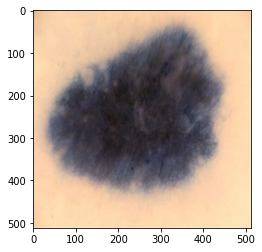

In [2]:
#数据增强（增加多样性，防止过拟合）
img = cv2.imread("/home/xhzhu/data/my_siim/512x512-dataset-melanoma/512x512-dataset-melanoma/ISIC_0000000.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)

torch.Size([3, 512, 512])


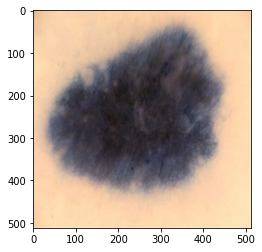

In [3]:
#最基础常用的数据增强
"""
函数定义:
ToTensor(num_classes=1, sigmoid=True, normalize=None)
说明：
将图片进行归一化（除以255）以及将array转为tensor，但是维度会发生变化，所以如果要显示图片需要转换维度
"""
img1 = A.Compose([
           ToTensorV2(p=1.0),
        ], p=1.0)(image=img)['image']
print(img1.shape)
img1 = np.transpose(img1, [1,2,0])
plt.imshow(img1)

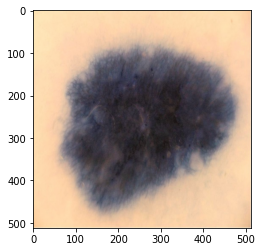

In [4]:
"""
函数定义:
RandomRotate90(always_apply=False, p=0.5)
说明：
指定概率随机多次或0次旋转90度
"""
img2 = A.Compose([
          A.RandomRotate90(p=1)
        ], p=1.0)(image=img)['image']
plt.imshow(img2)

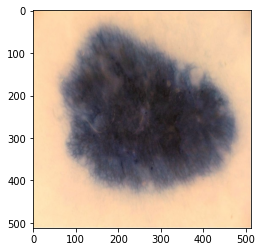

In [5]:
"""
函数定义:
HorizontalFlip(always_apply=False, p=0.5)
说明：
指定概率水平翻转图片
"""
img3 = A.Compose([
          A.HorizontalFlip(p=1)
        ], p=1.0)(image=img)['image']
plt.imshow(img3)

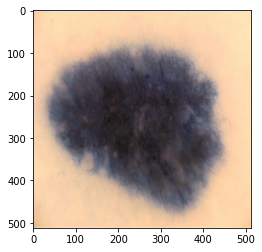

In [6]:
"""
函数定义:
VerticalFlip(always_apply=False, p=0.5)
说明：
指定概率垂直翻转图片
"""
img4 = A.Compose([
          A.VerticalFlip(p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img4)

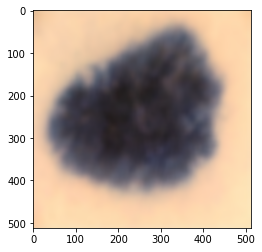

In [7]:
"""
函数定义:
Blur(blur_limit=7, always_apply=False, p=0.5)
说明：
指定概率模糊图片
"""
img5 = A.Compose([
          A.Blur(blur_limit=100,p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


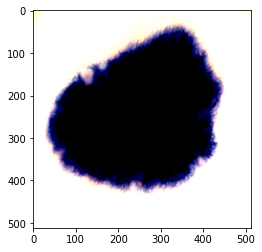

In [8]:
"""
函数定义:
Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0)
说明：
以一定概率将像素值除以255 = 2 ** 8-1，减去每个通道的平均值，再除以每个通道的std，正则化。
"""
img6 = A.Compose([
          A.Normalize(p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img6)

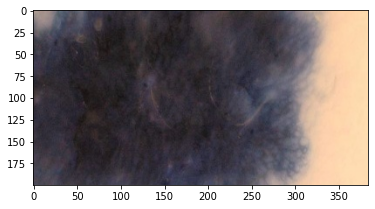

In [9]:
"""
函数定义:
RandomCrop(height, width, always_apply=False, p=1.0)
说明：
随机切片
"""
img7 = A.Compose([
          A.RandomCrop(200,384,p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img7)

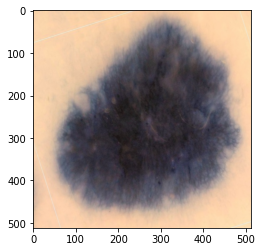

In [10]:
"""
函数定义:
ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5)
说明：
随机应用仿射变换：平移，缩放和旋转
"""
img8 = A.Compose([
          A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.60, rotate_limit=45, p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img8)

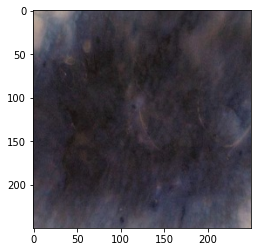

In [11]:
"""
函数定义:
CenterCrop(height, width, always_apply=False, p=1.0)
说明：
中心切片
"""
img9 = A.Compose([
          A.CenterCrop(250, 250, p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img9)

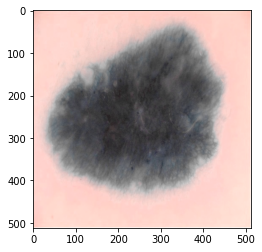

In [12]:
"""
函数定义:
HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, always_apply=False, p=0.5)
说明：
随机更改输入图像的色相，饱和度和值。
"""
img10 = A.Compose([
          A.HueSaturationValue(p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img10)

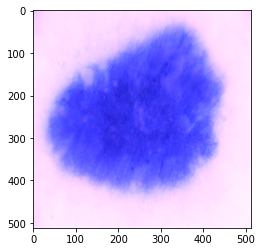

In [13]:
"""
函数定义:
RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.5)
说明：
随机抖动（平移）rgb通道的值
"""
img11 = A.Compose([
          A.RGBShift(r_shift_limit=100, g_shift_limit=20, b_shift_limit=200, p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img11)

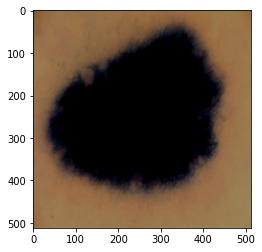

In [14]:
"""
函数定义:
RandomBrightness(limit=0.2, always_apply=False, p=0.5)
说明：
随机改变图片的亮度
"""
img12 = A.Compose([
          A.RandomBrightness(limit=0.8, p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img12)

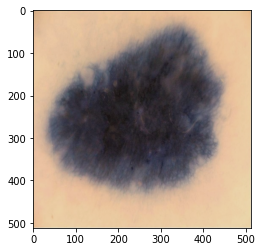

In [15]:
"""
函数定义:
RandomContrast(limit=0.2, always_apply=False, p=0.5)
说明：
随机改变图片的对比度
"""
img13 = A.Compose([
          A.RandomContrast(limit=0.9, p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img13)

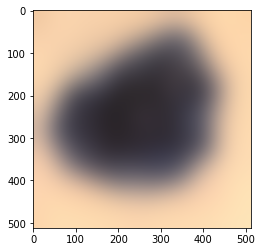

In [16]:
"""
函数定义:
GaussianBlur(blur_limit=7, always_apply=False, p=0.5)
说明：
以一定概率使用具有随机核大小的高斯滤波器对输入图像进行模糊处理
"""
img14 = A.Compose([
          A.GaussianBlur(blur_limit=200, p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img14)

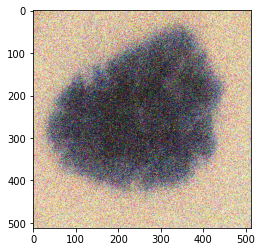

In [17]:
"""
函数定义:
GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5)
说明：
以一定概率将高斯噪声应用于输入图像
"""
img15 = A.Compose([
          A.GaussNoise(var_limit=(1000.0, 50000.0), p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img15)

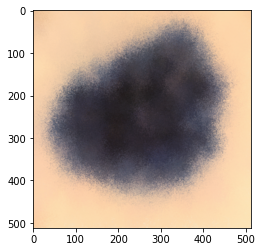

In [18]:
"""
函数定义:
GlassBlur(sigma=0.7, max_delta=4, iterations=2, always_apply=False, mode='fast', p=0.5)
说明：
以一定概率对输入图像应用玻璃噪声。
"""
img16 = A.Compose([
          A.GlassBlur(sigma=0.7, max_delta=4, iterations=20, p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img16)

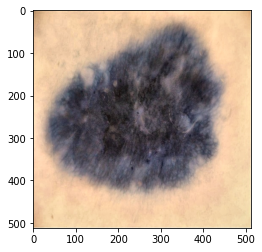

In [19]:
"""
函数定义:
CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
说明：
以一定概率将对比度受限的自适应直方图均衡应用于输入图像
"""
img17 = A.Compose([
          A.CLAHE(p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img17)

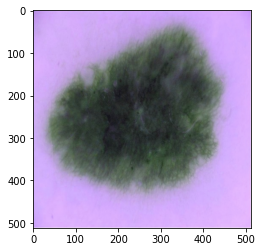

In [20]:
"""
函数定义:
ChannelShuffle(always_apply=False, p=0.5)
说明：
以一定概率随机重新排列输入RGB图像的通道
"""
img18 = A.Compose([
          A.ChannelShuffle(p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img18)

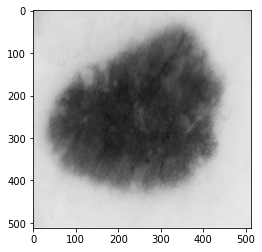

In [21]:
"""
函数定义:
ToGray(always_apply=False, p=0.5)
说明：
以一定概率转为灰度图
"""
img19 = A.Compose([
          A.ToGray(p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img19)

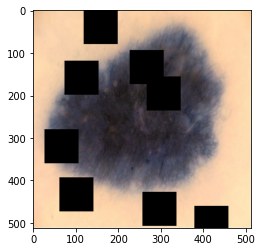

In [22]:
"""
函数定义:
Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5)
说明：
以一定概率在图片上以方框覆盖
"""
img20 = A.Compose([
          A.Cutout(max_h_size=80, max_w_size=80, p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img20)

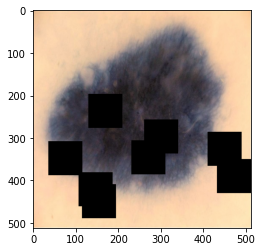

In [23]:
"""
函数定义:
CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=None, min_height=None, min_width=None, fill_value=0, always_apply=False, p=0.5)
说明：
以一定概率在图片上以方框覆盖，和cutout很类似，加了一些限制，而且cutout可以在图片外切,但它一定在图片内
"""
img21 = A.Compose([
          A.CoarseDropout(max_height=80, max_width=80, p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img21)

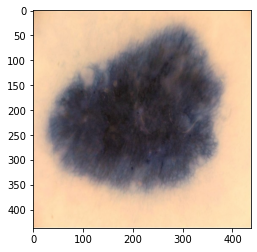

In [24]:
"""
函数定义:
RandomScale(scale_limit=0.1, interpolation=1, always_apply=False, p=0.5)
说明：
随机调整输入大小。 输出图像尺寸与输入图像尺寸不同。
"""
img22 = A.Compose([
          A.RandomScale(scale_limit=0.5, p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img22)

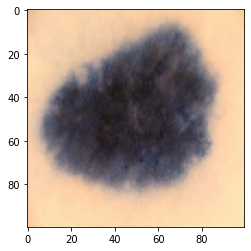

In [25]:
"""
函数定义:
Resize(height, width, interpolation=1, always_apply=False, p=1)
说明：
改变图像大小,注意resize的interinterpolation字段，这个字段代表五种插值方法，默认线性插值
五种线性插值分别为cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA, cv2.INTER_LANCZOS4
其中缩小图片时最好使用区域插值cv2.INTER_AREA，而要放大图像，通常使用INTER_CUBIC(速度较慢，但效果最好)，
或者使用INTER_LINEAR(速度较快，效果还可以)，cv2.INTER_LANCZOS4不管是放大还是缩小图片效果都不错
速度比较：INTER_NEAREST（最近邻插值)>INTER_LINEAR(线性插值)>INTER_CUBIC(三次样条插值)>INTER_AREA(区域插值)
"""
img23 = A.Compose([
          A.Resize(100, 100, p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img23)

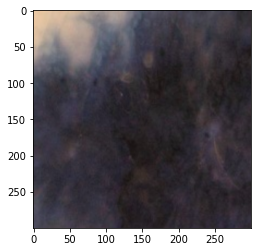

In [26]:
"""
函数定义:
RandomSizedCrop(min_max_height, height, width, w2h_ratio=1.0, interpolation=1, always_apply=False, p=1.0)
RandomResizedCrop(height, width, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1, always_apply=False, p=1.0)
说明：
以一定概率裁剪输入的随机部分，然后将其重新缩放为一定大小。这俩很类似
"""
img24 = A.Compose([
          A.RandomSizedCrop(min_max_height=(200,200), height=300, width=300,p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img24)

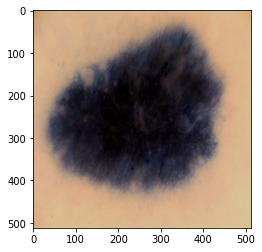

In [27]:
"""
函数定义:
RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=0.5)
说明：
以一定概率随机修改图片的亮度和对比度
"""
img25 = A.Compose([
          A.RandomBrightnessContrast(p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img25)

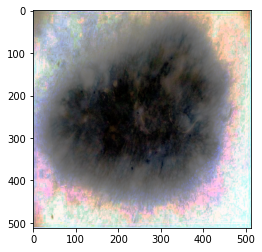

In [28]:
"""
函数定义:
Equalize(mode='cv', by_channels=True, mask=None, mask_params=(), always_apply=False, p=0.5)
说明：
以一定概率均衡化图像直方图。
"""
img26 = A.Compose([
          A.Equalize(mode='cv', by_channels=True, mask=None, mask_params=(), always_apply=False, p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img26)

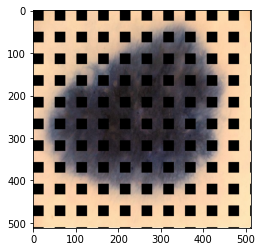

In [29]:
"""
函数定义:
GridDropout(ratio: float = 0.5, unit_size_min: int = None, unit_size_max: int = None, holes_number_x: int = None, holes_number_y: int = None, shift_x: int = 0, shift_y: int = 0, random_offset: bool = False, fill_value: int = 0, mask_fill_value: int = None, always_apply: bool = False, p: float = 0.5)
说明：
以一定概率以网格化的形式给图片填充特定像素值的方块，如下图，和gridmask类似
"""
img27 = A.Compose([
          A.GridDropout(p=1),
        ], p=1.0)(image=img)['image']
plt.imshow(img27)

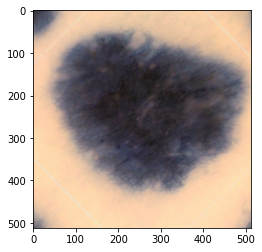

In [30]:
"""
综合例子：
其中oneof是多选一的操作，增加数据增强可变性，防止过拟合
"""
img28 = A.Compose([
         A.RandomRotate90(),
        # 翻转
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            # 高斯噪点
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            # 模糊相关操作
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            # 畸变相关操作
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            # 锐化、浮雕等操作
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ], p=1.0)(image=img)['image']
plt.imshow(img28)

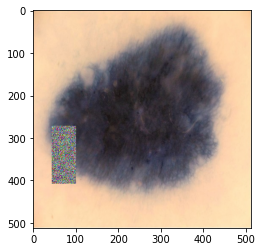

In [31]:
#其他数据增强的方法
"""
Random erasing：
Random erasing其实和cutout非常类似，也是一种模拟物体遮挡情况的数据增强方法。
区别在于，cutout每次裁剪掉的区域像素大小是固定的，Random erasing替换掉的区域像素大小是随机的, 使用随机数替换
"""
import random
import math
import cv2
import numpy as np
 
class RandomErasing:
    """Random erasing the an rectangle region in Image.
    Class that performs Random Erasing in Random Erasing Data Augmentation by Zhong et al.
    Args:
        sl: min erasing area region 
        sh: max erasing area region
        r1: min aspect ratio range of earsing region
        p: probability of performing random erasing
    """
 
    def __init__(self, p=0.5, sl=0.02, sh=0.4, r1=0.3):
 
        self.p = p
        self.s = (sl, sh)
        self.r = (r1, 1/r1)
    
 
    def __call__(self, img):
        """
        perform random erasing
        Args:
            img: opencv numpy array in form of [w, h, c] range 
                 from [0, 255]
        
        Returns:
            erased img
        """
 
        assert len(img.shape) == 3, 'image should be a 3 dimension numpy array'
 
        if random.random() > self.p:
            return img
        
        else:
            while True:
                Se = random.uniform(*self.s) * img.shape[0] * img.shape[1]
                re = random.uniform(*self.r) 
 
                He = int(round(math.sqrt(Se * re)))
                We = int(round(math.sqrt(Se / re)))
 
                xe = random.randint(0, img.shape[1])
                ye = random.randint(0, img.shape[0])
 
                if xe + We <= img.shape[1] and ye + He <= img.shape[0]:
                    img[ye : ye + He, xe : xe + We, :] = np.random.randint(low=0, high=255, size=(He, We, img.shape[2]))
 
                    return img
 

RE = RandomErasing(p=1,sl=0.02, sh=0.04, r1=0.03)
img29 = RE(img.copy())
plt.imshow(img29)

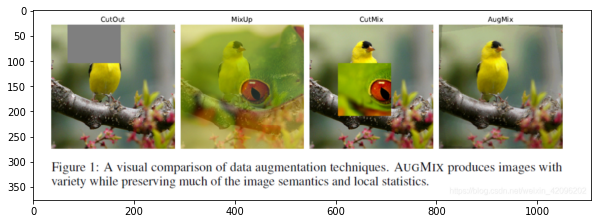

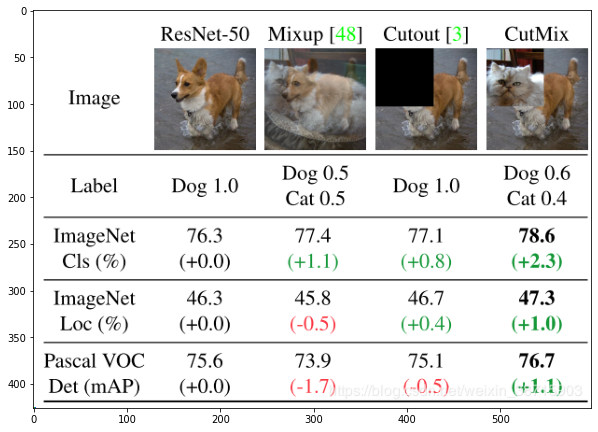

In [32]:
"""
四大类：cutout,mixup,cutmix,augmix
博客地址：https://blog.csdn.net/weixin_42096202/article/details/103459345
博客地址：https://blog.csdn.net/weixin_38715903/article/details/103999227
"""
img_cut = cv2.imread("/home/xhzhu/mycode/siim_code/tttt/20191209155033994.png")
img_cutt = cv2.cvtColor(img_cut, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,20))
plt.subplot(2, 1, 1)
plt.imshow(img_cutt)
img_cut = cv2.imread("/home/xhzhu/mycode/siim_code/tttt/20200116092100859.png")
img_cutt = cv2.cvtColor(img_cut, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,20))
plt.subplot(2, 1, 2)
plt.imshow(img_cutt)

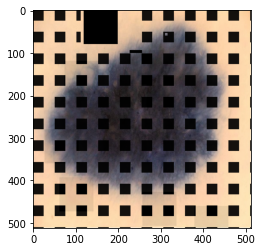

In [38]:
"""
cutmix代码解析：
博客地址：https://blog.csdn.net/weixin_38715903/article/details/103999227
GitHub原址：https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py
"""

"""train.py 279-295行"""
"""输入为：样本的size和生成的随机lamda值"""
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    """1.论文里的公式2，求出B的rw,rh"""
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)
 
    # uniform
    """2.论文里的公式2，求出B的rx,ry（bbox的中心点）"""
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    #限制坐标区域不超过样本大小
 
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    """3.返回剪裁B区域的坐标值"""
    return bbx1, bby1, bbx2, bby2
    
"""train.py 220-244行"""
def example():
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
 
        input = input.cuda()
        target = target.cuda()
        r = np.random.rand(1)
        if args.beta > 0 and r < args.cutmix_prob:
            # generate mixed sample
            """1.设定lamda的值，服从beta分布"""
            lam = np.random.beta(args.beta, args.beta)
            """2.找到两个随机样本"""
            rand_index = torch.randperm(input.size()[0]).cuda()
            target_a = target#一个batch
            target_b = target[rand_index] #batch中的某一张
            """3.生成剪裁区域B"""
            bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
            """4.将原有的样本A中的B区域，替换成样本B中的B区域"""
            input[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]
            # adjust lambda to exactly match pixel ratio
            """5.根据剪裁区域坐标框的值调整lam的值"""
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
            # compute output
            """6.将生成的新的训练样本丢到模型中进行训练"""
            output = model(input)
            """7.按lamda值分配权重"""
            loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
        else:
            # compute output
            output = model(input)
            loss = criterion(output, target)
beta = 0.1
lam = np.random.beta(beta, beta)
img_cop = np.transpose(img27, (2,0,1))
img_cop = img_cop[np.newaxis,:]
bbx1, bby1, bbx2, bby2 = rand_bbox(img_cop.shape, lam)
img_copy = img27
img_copy[bbx1:bbx2, bby1:bby2,:] = img20[bbx1:bbx2, bby1:bby2, :]
im_cutmix = (img27*lam+img20*(1-lam)).astype(np.uint8)
plt.imshow(im_cutmix)

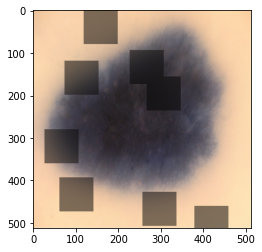

In [34]:
"""
mixup代码解析：
知乎源码地址：https://www.zhihu.com/question/308572298
mixup和sample pairing类似
sample pairing:
从数据集中随机挑选出一幅图像A，该图具有标签A（可以理解为图像A的种类，比如图像A是一幅猫的图，那么标签A就是猫），
于此同时随机挑选一个图像B，该图具有标签B，B标签可能和A标签相同，也可不同；然后A图B图进行常规的图像增广（旋转、
改变颜色、模糊、加入随机噪声等等）；然后从A、B中挑出一个patch，该patch从文章给出的尺寸来看几乎就是全图
（实际使用中我测试过用全图进行合成，效果没有明显差别）；然后将pathA和patchB进行混合，混合方式很简单，
就是将A和B在三个通道（RGB）上求均值，得到一个混合后的patch，但是这个patch依然还是使用标签A 作为它的类别，
然后将这个合成patch送入网络进行训练。
sample pairing文章解析：https://blog.csdn.net/xiaoxifei/article/details/90408243
"""
def example():
    for i,(images,target) in enumerate(train_loader):
        # 1.input output
        images = images.cuda(non_blocking=True)
        target = torch.from_numpy(np.array(target)).float().cuda(non_blocking=True)

        # 2.mixup
        alpha=config.alpha
        lam = np.random.beta(alpha,alpha)
        index = torch.randperm(images.size(0)).cuda()
        inputs = lam*images + (1-lam)*images[index,:]
        targets_a, targets_b = target, target[index]
        outputs = model(inputs)
        loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

        # 3.backward
        optimizer.zero_grad()   # reset gradient
        loss.backward()
        optimizer.step()        # update parameters of net
lam= 5*0.1
im_mixup = (img14*lam+img20*(1-lam)).astype(np.uint8)
plt.imshow(im_mixup)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


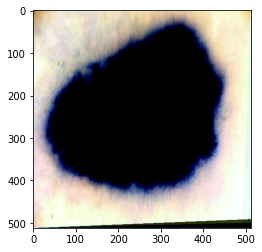

In [36]:
"""
augmix代码解析：
博客解说地址：https://blog.csdn.net/weixin_42096202/article/details/103459345
GitHub源码：https://github.com/google-research/augmix/blob/master/augment_and_mix.py
GitHub源码：https://github.com/google-research/augmix/blob/master/cifar.py
"""
#需要注意的是，augmentations文件里有个关于size的定义，如果你的图片和那里的不一致，你需要修改size大小
import augmentations
from torchvision import transforms
from PIL import Image
def aug(image, preprocess): 
    """Perform AugMix augmentations and compute mixture.   
    Args: 
    image: PIL.Image input image 
    preprocess: Preprocessing function which should return a torch tensor.   
    Returns: 
    mixed: Augmented and mixed image. 
    """ 
    #我自己定义的高度和宽度
    mixture_width = 3
    mixture_depth = 1
    aug_severity = 3
    
    ws = np.float32(np.random.dirichlet([1] * mixture_width)) 
    m = np.float32(np.random.beta(1, 1)) 

    mix = torch.zeros_like(preprocess(image)) 
    for i in range(mixture_width): 
        image_aug = image.copy() 
        depth = mixture_depth if mixture_depth > 0 else np.random.randint( 1, 4) 
        for _ in range(depth): 
            op = np.random.choice(augmentations.augmentations) 
            image_aug = apply_op(image_aug,op, aug_severity) 
        # Preprocessing commutes since all coefficients are convex 
        #  k个增广加权融合
        mix += ws[i] * preprocess(image_aug) 
   #  与原图加权融合
    mixed = (1 - m) * preprocess(image) + m * mix 
    return mixed 

preprocess = transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize([0.5] * 3, [0.5] * 3)
      ])

def apply_op(image, op, severity):
    #image = np.clip(image * 255., 0, 255).astype(np.uint8)
    pil_img = Image.fromarray(image)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)
    return np.asarray(pil_img) / 255.

def normalize(image):
    """Normalize input image channel-wise to zero mean and unit variance."""
    image = image.transpose(2, 0, 1)  # Switch to channel-first
    MEAN = [np.mean(image[0,:,:]), np.mean(image[1,:,:]), np.mean(image[2,:,:])]
    STD = [np.std(image[0,:,:]), np.std(image[1,:,:]), np.std(image[2,:,:])]
    mean, std = np.array(MEAN), np.array(STD)
    image = (image - mean[:, None, None]) / std[:, None, None]
    return image.transpose(1, 2, 0)

def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1.):
    """Perform AugMix augmentations and compute mixture.
    Args:
    image: Raw input image as float32 np.ndarray of shape (h, w, c)
    severity: Severity of underlying augmentation operators (between 1 to 10).
    width: Width of augmentation chain
    depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
      from [1, 3]
    alpha: Probability coefficient for Beta and Dirichlet distributions.
    Returns:
    mixed: Augmented and mixed image.
  """
    ws = np.float32(
    np.random.dirichlet([alpha] * width))
    m = np.float32(np.random.beta(alpha, alpha))

    mix = np.zeros_like(image).astype('float64')
    for i in range(width):
        image_aug = image.copy()
        depth = depth if depth > 0 else np.random.randint(1, 4)
        for _ in range(depth):
            op = np.random.choice(augmentations.augmentations)
            image_aug = apply_op(image_aug, op, severity)

        mix += ws[i] * normalize(image_aug)
    mixed = (1 - m) * normalize(image) + m * mix
    return mixed
#两个函数都能用，只是正则化不同
img30 = augment_and_mix(img,depth=1)
#mg30 = aug(img, preprocess)
plt.imshow(img30)

(222, 26, 3)
(290, 26, 3)
(222, 486, 3)
(290, 486, 3)


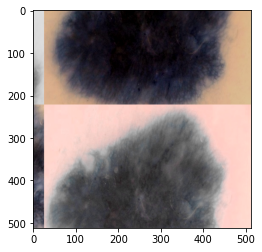

In [60]:
"""
RICAP,全称：Random image cropping and patching
文章解析：https://blog.csdn.net/weixin_42990464/article/details/104653043
github源码：https://github.com/4uiiurz1/pytorch-ricap/blob/master/train.py
"""
def example():
     for i, (input, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        # from original paper's appendix
        if args.ricap:
            I_x, I_y = input.size()[2:]

            w = int(np.round(I_x * np.random.beta(args.ricap_beta, args.ricap_beta)))
            h = int(np.round(I_y * np.random.beta(args.ricap_beta, args.ricap_beta)))
            w_ = [w, I_x - w, w, I_x - w]
            h_ = [h, h, I_y - h, I_y - h]

            cropped_images = {}
            c_ = {}
            W_ = {}
            for k in range(4):
                idx = torch.randperm(input.size(0))
                x_k = np.random.randint(0, I_x - w_[k] + 1)
                y_k = np.random.randint(0, I_y - h_[k] + 1)
                cropped_images[k] = input[idx][:, :, x_k:x_k + w_[k], y_k:y_k + h_[k]]
                c_[k] = target[idx].cuda()
                W_[k] = w_[k] * h_[k] / (I_x * I_y)

            patched_images = torch.cat(
                (torch.cat((cropped_images[0], cropped_images[1]), 2),
                torch.cat((cropped_images[2], cropped_images[3]), 2)),
            3)
            patched_images = patched_images.cuda()

            output = model(patched_images)
            loss = sum([W_[k] * criterion(output, c_[k]) for k in range(4)])

            acc = sum([W_[k] * accuracy(output, c_[k])[0] for k in range(4)])
            
def my_ricap_test():
    #这个也可以自定义
    ricap_beta = 0.3
    img_t1 = [img19, img17, img25, img10]
    #自定义尺寸，本来是要根据图片自己选择的
    I_x, I_y = 512, 512

    w = int(np.round(I_x * np.random.beta(ricap_beta, ricap_beta)))
    h = int(np.round(I_y * np.random.beta(ricap_beta, ricap_beta)))
    w_ = [w, I_x - w, w, I_x - w]
    h_ = [h, h, I_y - h, I_y - h]

    cropped_images = {}
    c_ = {}
    W_ = {}
    for k in range(4):
        x_k = np.random.randint(0, I_x - w_[k] + 1)
        y_k = np.random.randint(0, I_y - h_[k] + 1)
        cropped_images[k] = img_t1[k][x_k:x_k + w_[k], y_k:y_k + h_[k], :]
        print(cropped_images[k].shape)
        W_[k] = w_[k] * h_[k] / (I_x * I_y)

    patched_images = torch.cat((torch.cat((torch.tensor(cropped_images[0]), torch.tensor(cropped_images[1])), 0), 
                                torch.cat((torch.tensor(cropped_images[2]), torch.tensor((cropped_images[3]))), 0)),1)
    plt.imshow(patched_images)

my_ricap_test()